## **Zero-shot Text Classification: Sentiment-Analysis** ##

### **Model**: <u>facebook/bart-large-mnli</u> ##

Link: https://huggingface.co/facebook/bart-large-mnli

In [1]:
import torch

torch.backends.mps.is_built()

True

In [2]:
import pandas as pd

df =  pd.read_csv('../../data/test.csv')

print(df.isnull().sum())

df.head(3)

conversation_id    0
message            0
sentiment          0
dtype: int64


,conversation_id,message,sentiment
0,5748,"Nice. My Zeppelin only goes0.160 mph, so I do...",Happy
1,3347,That is a lot! And 60 million of them are in t...,Surprised
2,7034,well i'm not sure if it was a government or a...,Surprised


In [3]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from transformers.pipelines import Pipeline
from typing import Optional
import torch

def load_model(task: Optional[str]="zero-shot-classification",
               model_name: Optional[str]="facebook/bart-large-mnli") -> Pipeline:
    
    """
        Load model from Hugging Face Transformers library with pretrained
        weights and tokenizer and return a pipeline object.
    """

    device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")

    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, verbose=False, return_tensors="pt")
    model = AutoModelForSequenceClassification.from_pretrained(model_name, verbose=False)

    print("Running on device: ", device)

    classifier = pipeline(task=task, 
                          model=model, 
                          tokenizer=tokenizer,
                          device=device)
    
    return classifier


/Users/user/anaconda3/envs/splore/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
## Test ## 

message = df.message[1]
ground_truth = df.sentiment[1]
y_labels = df.sentiment.unique().tolist()

classifier = load_model()
res = classifier(message, y_labels, multi_label=False)

print(f"Message: {message}")
print(f"Labels: {y_labels}")

print("\nPrediction:")
print(f"Predicted label: {res['labels'][0]} | Confidence: {res['scores'][0]:.2f}")
print(f"Ground Truth: {ground_truth}")


Running on device:  mps
Message: That is a lot! And 60 million of them are in the United States! thats about 1/5 people here
Labels: ['Happy', 'Surprised', 'Curious to dive deeper', 'Neutral', 'Sad', 'Fearful', 'Angry', 'Disgusted']

Prediction:
Predicted label: Surprised | Confidence: 0.68
Ground Truth: Surprised


In [5]:
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import time

def evaluate_and_save_batches(df: pd.DataFrame, classifier: Pipeline, batch_size: int, output_file: Path) -> None:

    if not os.path.exists(output_file):
        os.makedirs(output_file.parent, exist_ok=True)

    y_labels = df['sentiment'].unique().tolist()
    num_batches = len(df) // batch_size + (1 if len(df) % batch_size != 0 else 0)
    
    for i in range(num_batches):
        batch = df.iloc[i*batch_size : (i+1)*batch_size]
        y_true_batch = batch['sentiment'].tolist()
        indices_batch = batch.index.tolist()
        y_pred_batch = []
        y_pred_conf = []

        for message in batch['message']:
            s_time = time.perf_counter()
            res = classifier(message, y_labels, multi_label=False)
            y_pred_batch.append(res['labels'][0])
            y_pred_conf.append(round(res['scores'][0], 2))
            e_time = time.perf_counter()

        batch_df = pd.DataFrame({'index': indices_batch, 'y_true': y_true_batch, 'y_pred': y_pred_batch, 'y_pred_conf': y_pred_conf, 'time': e_time-s_time})
        
        if i == 0:
            batch_df.to_csv(output_file, index=False, mode='w')
        else:
            batch_df.to_csv(output_file, index=False, mode='a', header=False)
        
        print(f"Processed and saved batch {i+1}/{num_batches}")

def load_and_evaluate(output_file: Path) -> None:
    combined_df = pd.read_csv(output_file)
    y_true = combined_df['y_true']
    y_pred = combined_df['y_pred']
    y_labels = y_true.unique().tolist()

    cm = confusion_matrix(y_true, y_pred, labels=y_labels)
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_labels, yticklabels=y_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Ground Truth')
    plt.title('Confusion Matrix')
    plt.show()

    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=y_labels))

In [6]:
savepath = Path("../../result/bart-sentiment-predictions.csv")

evaluate_and_save_batches(df, classifier, batch_size=50, output_file=savepath)

Processed and saved batch 1/227
Processed and saved batch 2/227
Processed and saved batch 3/227
Processed and saved batch 4/227
Processed and saved batch 5/227
Processed and saved batch 6/227
Processed and saved batch 7/227
Processed and saved batch 8/227
Processed and saved batch 9/227
Processed and saved batch 10/227
Processed and saved batch 11/227
Processed and saved batch 12/227
Processed and saved batch 13/227
Processed and saved batch 14/227
Processed and saved batch 15/227
Processed and saved batch 16/227
Processed and saved batch 17/227
Processed and saved batch 18/227
Processed and saved batch 19/227
Processed and saved batch 20/227
Processed and saved batch 21/227
Processed and saved batch 22/227
Processed and saved batch 23/227
Processed and saved batch 24/227
Processed and saved batch 25/227
Processed and saved batch 26/227
Processed and saved batch 27/227
Processed and saved batch 28/227
Processed and saved batch 29/227
Processed and saved batch 30/227
Processed and saved

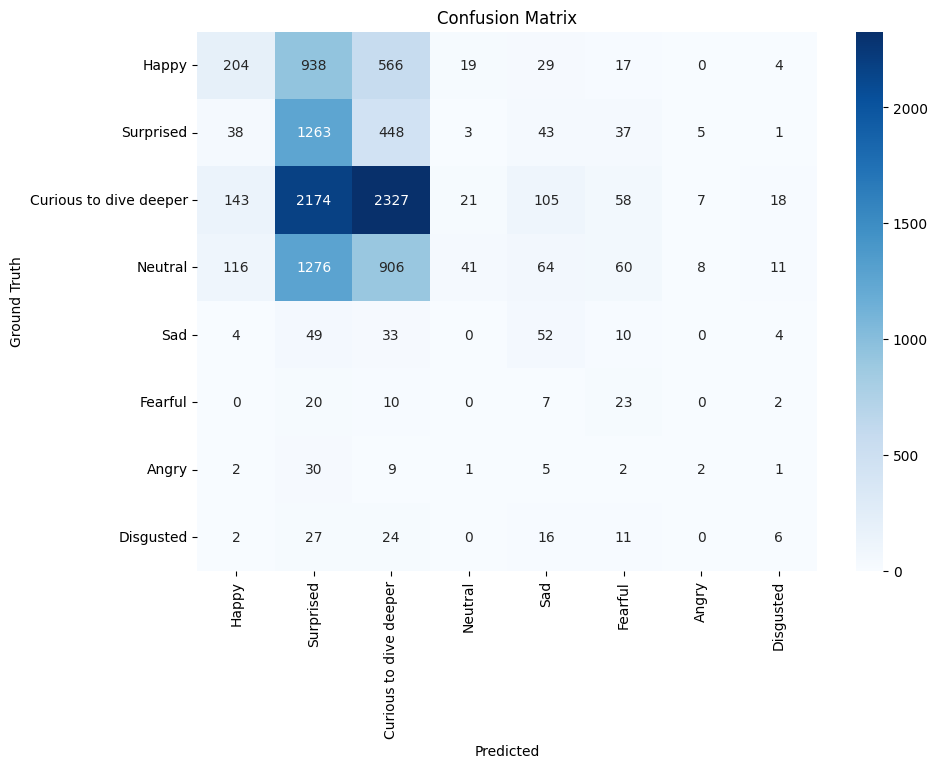

Classification Report:

                        precision    recall  f1-score   support

                 Happy       0.09      0.04      0.05        52
             Surprised       0.54      0.48      0.51      4853
Curious to dive deeper       0.13      0.07      0.09        86
               Neutral       0.11      0.37      0.16        62
                   Sad       0.40      0.11      0.18      1777
               Fearful       0.48      0.02      0.03      2482
                 Angry       0.16      0.34      0.22       152
             Disgusted       0.22      0.69      0.33      1838

              accuracy                           0.35     11302
             macro avg       0.27      0.26      0.20     11302
          weighted avg       0.44      0.35      0.31     11302



In [7]:
load_and_evaluate(output_file=savepath)

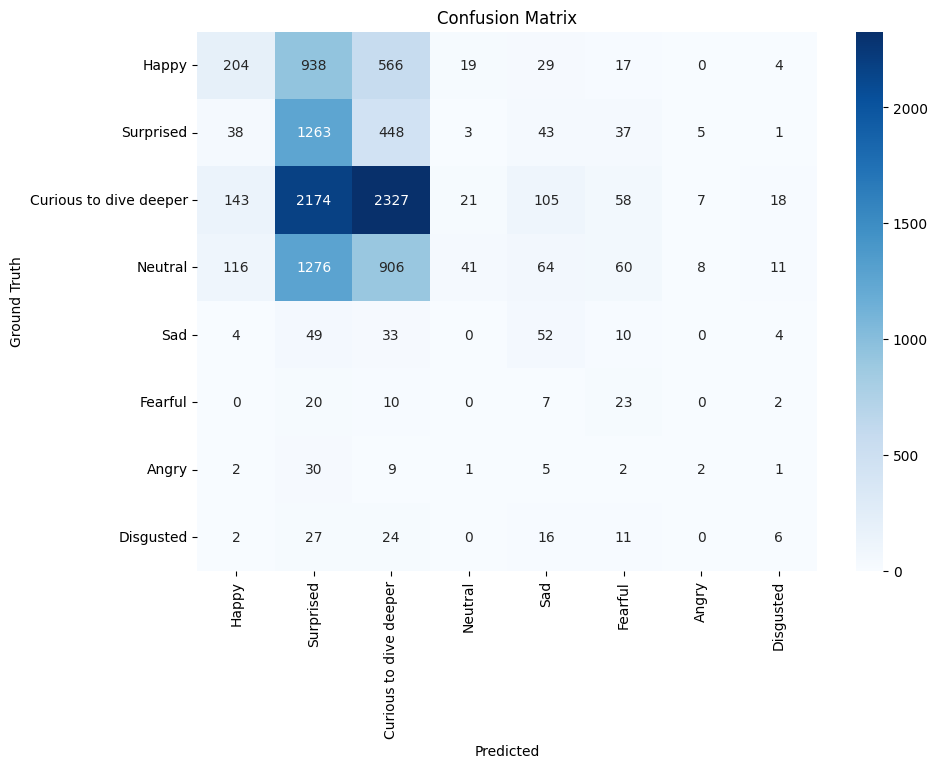

In [15]:
combined_df = pd.read_csv(savepath)
y_true = combined_df['y_true']
y_pred = combined_df['y_pred']
y_labels = y_true.unique().tolist()

cm = confusion_matrix(y_true, y_pred, labels=y_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix')
plt.show()

report_dict = classification_report(y_true, y_pred, target_names=y_labels, output_dict=True)
cm = confusion_matrix(y_true, y_pred)

report_df = pd.DataFrame(report_dict).transpose()

cm_df = pd.DataFrame(cm, index=y_labels, columns=y_labels)

with pd.ExcelWriter('../../result/bart-sentiment-metrics.xlsx') as writer:
    report_df.to_excel(writer, sheet_name='Classification Report')
    cm_df.to_excel(writer, sheet_name='Confusion Matrix')

In [20]:
df = pd.read_csv('../../result/bart-sentiment-predictions.csv')

df.time.mean()

0.2799361267178748

## **Overall Code** ##

- Using confidence score and time taken as performance in inferencing

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from transformers.pipelines import Pipeline
from typing import Optional
from sklearn.metrics import confusion_matrix, classification_report
from pathlib import Path
import time
import torch
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def load_model(task: Optional[str]="zero-shot-classification",
               model_name: Optional[str]="facebook/bart-large-mnli") -> Pipeline:
    
    """
        Load model from Hugging Face Transformers library with pretrained
        weights and tokenizer and return a pipeline object.
    """

    device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")

    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, verbose=False, return_tensors="pt")
    model = AutoModelForSequenceClassification.from_pretrained(model_name, verbose=False)

    print("Running on device: ", device)

    classifier = pipeline(task=task, 
                          model=model, 
                          tokenizer=tokenizer,
                          device=device)
    
    return classifier


def evaluate_and_save_batches(df: pd.DataFrame, classifier: Pipeline, batch_size: int, output_file: Path) -> None:
    """
        Evaluate model in batches and save the results to a CSV file.
        Saving the following columns: Index, Ground Truth Label, Predicted Label, Predicted Label Confidence, Time Taken to run inference
    """

    if not os.path.exists(output_file):
        os.makedirs(output_file.parent, exist_ok=True)

    y_labels = df['sentiment'].unique().tolist()
    num_batches = len(df) // batch_size + (1 if len(df) % batch_size != 0 else 0)
    
    for i in range(num_batches):
        batch = df.iloc[i*batch_size : (i+1)*batch_size]
        y_true_batch = batch['sentiment'].tolist()
        indices_batch = batch.index.tolist()
        y_pred_batch = []
        y_pred_conf = []

        for message in batch['message']:
            s_time = time.perf_counter()
            res = classifier(message, y_labels, multi_label=False)
            y_pred_batch.append(res['labels'][0])
            y_pred_conf.append(round(res['scores'][0], 2))
            e_time = time.perf_counter()

        batch_df = pd.DataFrame({'index': indices_batch, 'y_true': y_true_batch, 'y_pred': y_pred_batch, 'y_pred_conf': y_pred_conf, 'time': e_time-s_time})
        
        if i == 0:
            batch_df.to_csv(output_file, index=False, mode='w')
        else:
            batch_df.to_csv(output_file, index=False, mode='a', header=False)
        
        print(f"Processed and saved batch {i+1}/{num_batches}")

def load_and_evaluate(output_file: Path) -> None:
    """
        Load the predictions CSV file and evaluate the model's performance 
        by plotting the confusion matrix and printing the classification report.
    """
    combined_df = pd.read_csv(output_file)
    y_true = combined_df['y_true']
    y_pred = combined_df['y_pred']
    y_labels = y_true.unique().tolist()

    cm = confusion_matrix(y_true, y_pred, labels=y_labels)
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_labels, yticklabels=y_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Ground Truth')
    plt.title('Confusion Matrix')
    plt.show()

    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=y_labels))

    report_dict = classification_report(y_true, y_pred, target_names=y_labels, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)

    report_df = pd.DataFrame(report_dict).transpose()

    cm_df = pd.DataFrame(cm, index=y_labels, columns=y_labels)
    
    with pd.ExcelWriter('../../result/bart-sentiment-metrics.xlsx') as writer:
        report_df.to_excel(writer, sheet_name='Classification Report')
        cm_df.to_excel(writer, sheet_name='Confusion Matrix')


if __name__ == "__main__":
    df =  pd.read_csv('../../data/test.csv')
    savepath = Path("../../result/bart-sentiment-predictions.csv")

    classifier = load_model()
    evaluate_and_save_batches(df, classifier, batch_size=50, output_file=savepath)
    load_and_evaluate(output_file=savepath)


